# 💪🏽**Push Up Detector**💦✨
This model is designed to detect push up activity that consists of the up and down movement. The dataset will be in the form of stationary pose landmarks. One push up will be counted if the model detected several constant and continuous push up 'Up' pose followed by several constant and continuous push up 'Down' pose.

This notebook is presented to you by Bangkit Team C22-PS072's ML Squad💖:


*   Deandra Setyaputri - M2010F1120
*   Wilma Elysia - M7013F1348



## 0. Manage Dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python mediapipe matplotlib sklearn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import mediapipe as mp

## 1. Preprocess Input Images
First, create a copy of every image data where they are flipped horizontally so that the model can accurately detect push-up poses regardless if the user is facing left or right.

In [ ]:
from google.colab import drive

drive.mount("/content/drive") 
root = "/content/drive/My Drive/Datasets/pushup/"

pushup_up_folder = root + "pushup_up" + "/*.*"
pushup_down_folder = root + "pushup_down" + "/*.*"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def flip_img_folder(folder):
    for file in glob.glob(folder):
        image = cv2.imread(file)
        flipped_img_path = file[:-4] + "-reversed." + file[-3:]
        # file[:-4] is the name of the path and image name without the .jpg or .png extension

        if(file[-13:-4] != "-reversed" and os.path.exists(flipped_img_path) == False):
            flipped_img = cv2.flip(image, 1)
            cv2.imwrite(flipped_img_path, flipped_img)

In [ ]:
flip_img_folder(pushup_up_folder)
flip_img_folder(pushup_down_folder)

We will convert all the image data to arrays of landmarks representing the human pose in each image. Then create a csv file containing those data to be used in training later.

In [6]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

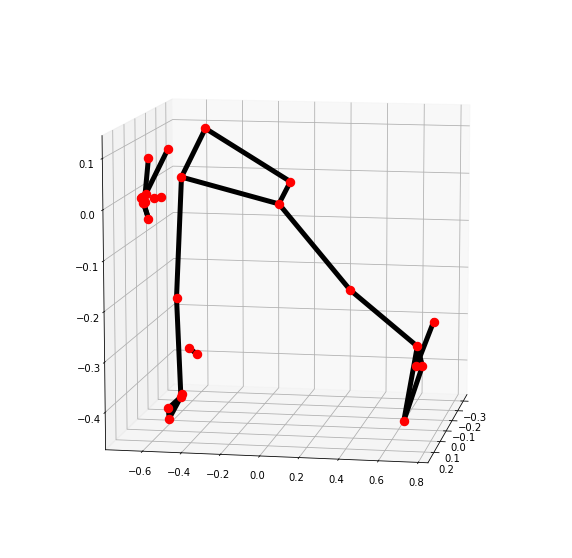

[[-6.62991822e-01  4.25729454e-02 -1.06931023e-01  9.99926805e-01]
 [-6.68921232e-01  6.21548295e-03 -1.42648920e-01  9.99785602e-01]
 [-6.68903887e-01  7.10422546e-03 -1.29456609e-01  9.99833107e-01]
 [-6.69384718e-01  7.61886686e-03 -1.32879615e-01  9.99833465e-01]
 [-6.86297834e-01 -2.82711536e-03 -1.24507189e-01  9.99886274e-01]
 [-6.84263468e-01 -3.50476801e-03 -1.37279943e-01  9.99930978e-01]
 [-6.70787871e-01 -7.69862533e-03 -1.16898008e-01  9.99942660e-01]
 [-6.08434439e-01 -9.10972878e-02 -1.98640049e-01  9.99886394e-01]
 [-5.87766290e-01 -9.11170095e-02 -5.15226349e-02  9.99907494e-01]
 [-6.29140317e-01  1.49506330e-03 -1.10243350e-01  9.99686837e-01]
 [-6.00891054e-01  5.45307994e-05 -9.79232043e-02  9.99693513e-01]
 [-4.47114110e-01 -5.29620200e-02 -1.84753180e-01  9.99890208e-01]
 [-5.12326479e-01 -1.04896523e-01  1.84171125e-01  9.99583304e-01]
 [-4.41985965e-01  1.75694197e-01 -2.49654055e-01  9.68457222e-01]
 [-4.22183812e-01  1.39876544e-01  1.81324005e-01  3.78025658e

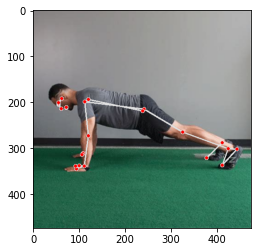

In [ ]:
# trying out the library
with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False, min_detection_confidence=0.5) as pose:
    for file in glob.glob(pushup_up_folder):
        image = cv2.imread(file)
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        break
    if results.pose_landmarks:
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS) # Draw pose connections
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        landmarks = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_world_landmarks.landmark])
        print(landmarks)

In [ ]:
def discard_unused_landmarks(landmarks):
    # take only from index 11 (shoulder) to 26 (knee)
    new_landmarks = landmarks.pose_world_landmarks.landmark[11:27]
    return new_landmarks

In [ ]:
def detect_pose_from_folder(folder, folder_label):
    with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False, min_detection_confidence=0.5) as pose:
        landmarks = []
        labels = []
        for file in glob.glob(folder):
            image = cv2.imread(file)
            results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.pose_landmarks:
                results_landmark = discard_unused_landmarks(results)
                landmark = np.array([[res.x, res.y, res.z, res.visibility] for res in results_landmark]).flatten()
                landmarks.append(landmark)
                labels.append(folder_label)
    return landmarks, labels

In [ ]:
# '1' is the label for the up pushup movement
pushup_up_landmarks, pushup_up_labels = detect_pose_from_folder(pushup_up_folder, 1)
pushup_down_landmarks, pushup_down_labels = detect_pose_from_folder(pushup_down_folder, 0)

In [ ]:
landmarks = pushup_up_landmarks + pushup_down_landmarks
labels = pushup_up_labels + pushup_down_labels

In [ ]:
print(len(landmarks))
print(len(labels))

376
376


In [ ]:
import random

X = np.array(landmarks)
y = np.array(labels)
dataset = [(X[i], y[i]) for i in range(0, len(labels))]
random.shuffle(dataset)
X.shape

(376, 64)

In [ ]:
import csv

# open the file in the write mode
with open('/content/drive/My Drive/Datasets/pushup/pushup_dataset_reduced_landmarks.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write the header to the csv file
    writer.writerow(['pushup_pose', 'pose_world_landmarks'])

    for landmark, label in dataset:
        writer.writerow([label, landmark])

## 2. Train Model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [ ]:
model = keras.Sequential([
        keras.layers.Input(shape=(64)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(2, activation="sigmoid")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 16,706
Trainable params: 16,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_val, y_val))

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 0s 6ms/step - loss: 0.1668 - accuracy: 0.9107
test loss, test acc: [0.16683050990104675, 0.9107142686843872]


In [ ]:
# test the model prediction
with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False, min_detection_confidence=0.5) as pose:
    for file in glob.glob(pushup_up_folder)[:3]:
        image = cv2.imread(file)
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        kp = np.array([[res.x, res.y, res.z, res.visibility] for res in discard_unused_landmarks(results)]).flatten()
        predd = model.predict(kp.reshape(1, 64))
        posee = np.argmax(predd)
        confidence = predd[0][posee]
        print(predd)
        print(posee)
        print(confidence)


[[0.0104824 0.9990602]]
1
0.9990602
[[0.21280506 0.8848121 ]]
1
0.8848121
[[0.12537187 0.95289385]]
1
0.95289385


## 3. Save The Model

In [ ]:
!pip install pyyaml h5py

In [ ]:
model.save('pushup-counter-with-reduced-landmark-and-sigmoid.h5')

## 4. Convert to TFlite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpjmwbphlr/assets


## 5. Create Push Up Counter with Webcam



```
!pip install gTTS ipython

from gtts import gTTS
from IPython.display import Audio

def text_to_speech(sentence):
    tts = gTTS(sentence) #Provide the string to convert to speech
    sound_file = '1.wav'
    tts.save(sound_file) #save the string converted to speech as a .wav file
    return sound_file

audio = text_to_speech('test')
Audio(audio, autoplay=True)

def allEqual(iterable):
    iterator = iter(iterable)
    
    try:
        firstItem = next(iterator)
    except StopIteration:
        return True
        
    for x in iterator:
        if x!=firstItem:
            return False
    return True

threshold = 0.75
history = []
fail_count = 0
pushup_count = 0
num_frames_requirement = 15
pushup_down_done = False

cap = cv2.VideoCapture(0)

with mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)

        results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        cv2.putText(frame, "push up count:"+str(pushup_count), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        if results.pose_world_landmarks:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS) # Draw pose connections
            live_landmarks = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_world_landmarks.landmark]).flatten()
#             print(live_landmarks)
            
            y_pred = model.predict(live_landmarks.reshape(1, 132))
            pushup_pose = np.argmax(y_pred)
            pose_confidence = y_pred[0][pushup_pose]

            if pose_confidence > threshold:
                # reset continuous fail count
                fail_count = 0

                history.append(pushup_pose)

                if len(history) >= (2*num_frames_requirement):
                    if allEqual(history[(-1*num_frames_requirement):]):
                        if history[(-1*num_frames_requirement)] != history[(-1*num_frames_requirement)-1]:
                            if allEqual(history[(-2*num_frames_requirement):(-1*num_frames_requirement)]):
                                if pushup_pose == 0:
                                    pushup_down_done = True
                                else:
                                    if pushup_down_done:
                                        pushup_count += 1
                                        pushup_down_done = False
                                        print(pushup_count)
                                        cv2.putText(frame, "push up count:"+str(pushup_count), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            else:
                fail_count += 1
                if fail_count > 15:
                    history = []
                    pushup_down_done = False

        cv2.imshow('OpenCV Feed', frame)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
```